<a href="https://colab.research.google.com/github/maiormarso/DS-Unit-2-Linear-Models/blob/master/LS_DS10_Sprint_Challenge_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍕

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Confusion Matrix
- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [3]:
train.shape, test.shape

((51916, 17), (17306, 17))

In [4]:
train['Inspection ID'].value_counts()

659454     1
1498062    1
1162210    1
1418209    1
2050914    1
          ..
1326893    1
1578792    1
1453818    1
1981826    1
1441792    1
Name: Inspection ID, Length: 51916, dtype: int64

In [5]:
train.head(1)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1


In [0]:
features = ['Inspection ID', 'Facility Type','Risk','Inspection Date','Inspection Type']
XXtrain  = train[features]
XXtest = test[features]

In [7]:
XXtrain.head(1)

,Inspection ID,Facility Type,Risk,Inspection Date,Inspection Type
0,2088270,Restaurant,Risk 1 (High),2017-09-15T00:00:00,Canvass


## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [0]:
X_train = XXtrain.sample(frac=0.7939) # 41532
#X_test  = test#d2.sample(frac=0.20)   # 2792 
X_test = XXtest.sample(frac=1)
y_train = train['Fail'].sample(frac=0.7939) #2792
y_test = test['Fail'].sample(frac=1)  # 17306
#val_test = X_train.sample(frac=0.10) # 1168
X_val = XXtest.sample(frac=0.10) # 1168
y_val = test['Fail'].sample(frac=.1)  # 17306

In [47]:
print('train      :',train.shape)
print('X_train :',X_train.shape) 
print('X_test  :',X_test.shape)
print('y_train :',y_train.shape)
print('y_test  :',y_test.shape)
#print('val_test:',val_test.shape)
print('X_val:',X_val.shape)
print('y_val:',y_val.shape)

train      : (51916, 17)
X_train : (41216, 5)
X_test  : (17306, 5)
y_train : (41216,)
y_test  : (17306,)
X_val: (1731, 5)
y_val: (1731,)


In [43]:
y_train.head(1)

31008    0
Name: Fail, dtype: int64

In [48]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
# What if we tried all the features?
#features = train.columns.drop([target, 'Fail'])
#

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

model = LogisticRegressionCV(cv=5, n_jobs=-1, random_state=42)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.7579433853264009


## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

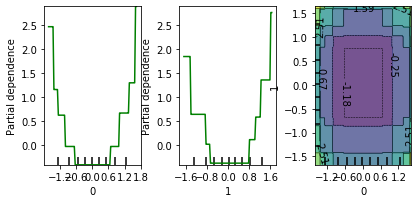

In [11]:
>>> from sklearn.datasets import make_hastie_10_2
>>> from sklearn.ensemble import GradientBoostingClassifier
>>> from sklearn.inspection import plot_partial_dependence

>>> X, y = make_hastie_10_2(random_state=0)
>>> clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
...     max_depth=1, random_state=0).fit(X, y)
>>> features = [0, 1, (0, 1)]
>>> plot_partial_dependence(clf, X, features) 